# Random Embedding vs Pretrained Embeddings

In our previous [summary notebook](https://github.com/sv650s/sb-capstone/blob/master/2019_07_30_deep_learning_summary.ipynb), we compared the results of various deep learning models and found that 1 Layer bidirection GRU with Attention gave us the most precision in our problem classes - 2, 3, and 4. This model's first embedding layer uses a random embedding

In this notebook, we will run the same model with some pre-trained embeddings and compare results. There were 4 total models that were executed (all 1 layer bidirectional GRU networks with attention):
* [Random Embedding (our base model)](https://github.com/sv650s/sb-capstone/blob/master/2019_07_25_biGRU_1layer_with_attention.ipynb)
* [Pre-trained Paragram Embedding](https://github.com/sv650s/sb-capstone/blob/master/2019_07_31_preloaded_embeddings-paragram.ipynb)
* [Pre-trained word2vec (normalized)](https://github.com/sv650s/sb-capstone/blob/master/2019_08_1_preloaded_embeddings_word2vec_normalized.ipynb)
* [Pre-trained word2vec (not normalized)](https://github.com/sv650s/sb-capstone/blob/master/2019_08_1_preloaded_embeddings_word2vec.ipynb)

Our hypothesis is that since we are using pre-trained embeddings, the training time should decrease. 

We will also compare precision and various scores to see if the models perform better or worse that random embeddings


Data and metrics from previous runs have been saved to CSV files from our [keras_util.ModelWrapper](https://github.com/sv650s/sb-capstone/blob/master/util/keras_util.py) class. We will load the data into this notebook and do the comparison




In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
DRIVE_DIR = "drive/My Drive/Springboard/capstone"

# add this to sys patch so we can import utility functions
sys.path.append(DRIVE_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd

# load reports from previous runs
REPORT_FILE = f"{DRIVE_DIR}/reports/2019-08-03-dl_prototype-report.csv"
report = pd.read_csv(REPORT_FILE, quotechar="'").sort_values("description")
report[["model_name", "description"]]

,model_name,description
3,biGRU_1layer_attention,1 Layer bidirectional GRU with attention
0,biGRU_1layer_attention-paragram,1 Layer bidirectional GRU with pre-trained emb...
2,biGRU_1layer_attention-word2vec_normalized,1 Layer bidirectional GRU with pre-trained emb...
1,biGRU_1layer_attention-word2vec,1 Layer bidirectional GRU with pre-trained emb...


## Training Time Comparison

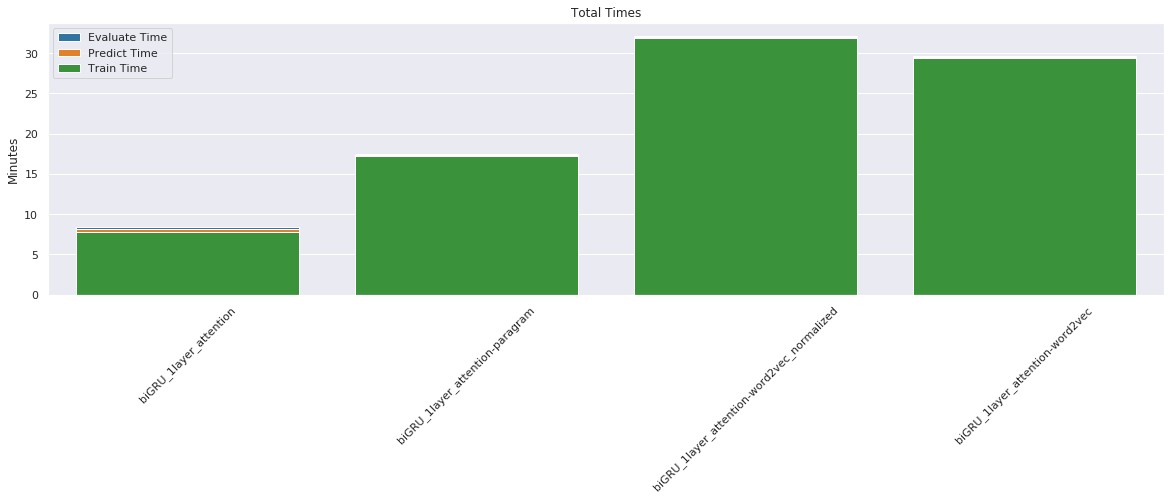

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

x = report.model_name.tolist()
# print(x)
train_times = report.train_time_min.tolist()
predict_times = (report.train_time_min + report.predict_time_min).tolist()
evaluate_times = (report.train_time_min + report.predict_time_min + report.evaluate_time_min).tolist()
# print(y)
f, a = plt.subplots(1, 1, figsize=(20,5))
# plot in reverse order since we are overlaying each layer
_ = sns.barplot(x, evaluate_times, color="tab:blue", label="Evaluate Time")
_ = sns.barplot(x, predict_times, color="tab:orange", label="Predict Time")
_ = sns.barplot(x, train_times, color="tab:green", label="Train Time")
a.legend(loc="upper left")
a.set_ylabel("Minutes")
a.set_title("Total Times")
_ = a.set_xticklabels(labels=x, rotation=45)

### Conclusion

Looks like all of our pre-training model did not out perform our random embedding model.

We should note that about 38% (15k out of 40k) of vocabulary from our reviews were not in pre-trained word2vec model and about 20% (7600 out of 40k) of vocabulary from paragram were not in pre-trained paragram model. Upon inspections, these were words that were generally mispells, model names like "iphone", etc. Words on in the vocabulary, we used randomly initialized word vectors. This could be the reason that training time took longer?



# Comparing Metrics

## Overall Accuracy

Looks like our random embedding model has higher accuracy overall

In [11]:
# Accuracy

report[["model_name", "accuracy"]]

,model_name,accuracy
3,biGRU_1layer_attention,0.678412
0,biGRU_1layer_attention-paragram,0.669594
2,biGRU_1layer_attention-word2vec_normalized,0.661811
1,biGRU_1layer_attention-word2vec,0.667845


# Classification Report

In [0]:
import util.dict_util as du
import pandas as pd
import json
import re

# let's load the classification report and dig in

cr_df = pd.DataFrame()
for i, row in report.iterrows():
  cr = json.loads(row.classification_report)
  # flatten out the report
  d = {}
  d["model_name"] = row.model_name
  d = du.add_dict_to_dict(d, cr)
  cr_df = cr_df.append(d, ignore_index=True)


## By F1 Score

F1 score is calculated from both precision and recall which balances the 2 metrics to give us one score. It should tell us a high level view of how well we are doing in each model

F1 = 2 * (precision * recall)/(precision + recall)


For the rest of the notebook, we will be sorting the results. I'm mostly looking at problem classes in this order: 2, 3, 4

Sorting is done in descending order so the best model will appear on the left

In [21]:

f1_columns = [col for col in cr_df.columns if re.search(r'\d_f1', col)]
f1_columns.append("model_name")
cr_df[f1_columns].set_index("model_name").sort_values(["2_f1-score", 
                                                       "3_f1-score", 
                                                       "4_f1-score", 
                                                       "1_f1-score", 
                                                       "5_f1-score"], ascending=False).T

model_name,biGRU_1layer_attention-paragram,biGRU_1layer_attention,biGRU_1layer_attention-word2vec,biGRU_1layer_attention-word2vec_normalized
1_f1-score,0.706390,0.720064,0.697213,0.698988
2_f1-score,0.128108,0.075274,0.046305,0.022369
3_f1-score,0.304462,0.354897,0.294883,0.280817
4_f1-score,0.312343,0.353978,0.305619,0.268669
5_f1-score,0.831926,0.836627,0.832397,0.826411


### F1 Score Conclusion

Paragram model performed the best on all problematic classes compared to the rest of the pre-trained models. It did better than random embedding model in class 2 but did worse in classes 3 and 4 - by 3 to 4%

## Precision and Recall

Let's dig deeper into precision and recall to see how each model did

In [22]:

# get only precision and recall columns
cols = [col for col in cr_df.columns if re.search(r"\d_precision", col) or re.search(r"\d_recall", col)]  
# add model name so we can use it as keys
cols.append("model_name")
cr_df[cols].set_index("model_name").sort_values(["2_precision", 
                                           "2_recall", 
                                           "3_precision", 
                                           "3_recall",
                                           "4_precision", 
                                           "4_recall",
                                          ], ascending=False).T

model_name,biGRU_1layer_attention,biGRU_1layer_attention-paragram,biGRU_1layer_attention-word2vec,biGRU_1layer_attention-word2vec_normalized
1_precision,0.655565,0.657335,0.599927,0.625473
1_recall,0.798639,0.763357,0.832157,0.792087
2_precision,0.346491,0.302789,0.295597,0.229167
2_recall,0.042223,0.081240,0.025120,0.011758
3_precision,0.359870,0.341009,0.341299,0.316337
3_recall,0.350059,0.274990,0.259581,0.252469
4_precision,0.440476,0.419058,0.417731,0.396064
4_recall,0.295875,0.248948,0.240951,0.203283
5_precision,0.778433,0.759328,0.766655,0.747002
5_recall,0.904225,0.919874,0.910471,0.924710


In [31]:
# let's look at confusion matrix fo the two models
model_name = "biGRU_1layer_attention"
print(model_name)

cm_base = pd.DataFrame()
for row in json.loads(report.loc[report.model_name == model_name, "confusion_matrix"].values[0]):
  cm_base = cm_base.append(pd.Series(row), ignore_index=True)
cm_base

biGRU_1layer_attention


,0,1,2,3,4
0,3169.0,80.0,368.0,49.0,302.0
1,881.0,79.0,513.0,153.0,245.0
2,472.0,52.0,886.0,549.0,572.0
3,130.0,12.0,491.0,1406.0,2713.0
4,182.0,5.0,204.0,1035.0,13463.0


In [32]:
# let's look at how many predictions our model did for each clas
cm_base.sum(axis='index')


0     4834.0
1      228.0
2     2462.0
3     3192.0
4    17295.0
dtype: float64

In [30]:
model_name = "biGRU_1layer_attention-paragram"
print(model_name)
cm_paragram = pd.DataFrame()
for row in json.loads(report.loc[report.model_name == model_name, "confusion_matrix"].values[0]):
  cm_paragram = cm_paragram.append(pd.Series(row), ignore_index=True)
cm_paragram

biGRU_1layer_attention-paragram


,0,1,2,3,4
0,3029.0,164.0,302.0,64.0,409.0
1,798.0,152.0,411.0,192.0,318.0
2,443.0,115.0,696.0,611.0,666.0
3,131.0,58.0,432.0,1183.0,2948.0
4,207.0,13.0,200.0,773.0,13696.0


In [33]:
# let's look at how many predictions our model did for each clas
cm_paragram.sum(axis='index')


0     4608.0
1      502.0
2     2041.0
3     2823.0
4    18037.0
dtype: float64

### Precision and Recall Conclusion

Now that we are looking at specifics, we can see that random embedding model actually did better than the rest in precision, meaning that when it does classify something as class 2, it is more likely to be actually a class 2 than the rest of the model. If you look at the confusion matrix results, paragram model predicted 502 reviews as class two compared to the 228 that base model did (almost 2x as likely to predict class 2). It is less like to be accurate though as only 152/502 were accurate (30%) compared to base model 79/152 (34.6%)

Random model actually did better in recall for class 2 than all pre-trained models except for paragram and did better in both precision and recall than the rest for class 3 and 4

You can explain the high F1 score for the paragram model by looking at class 2 recall - paragram mode's recall is about 4% higher than random embedding model which pushes our calculation of F1 score higher. Paragram model is more likely to classify a review as rating 2, but is less likely to be accurate in it's classification


By looking at this, it would suggest that our base model - random embedding is still the better model


# ROC AUC

We will now look at AUC for the model. AUC generally tells us which model is better at separating the classes. A higher score means that better the model is able to discern between classes

In [36]:
auc_df = pd.DataFrame()
for index, row in report.iterrows():
  roc_auc = json.loads(row.roc_auc)
  roc_auc["model_name"] = row.model_name
  auc_df = auc_df.append(roc_auc, ignore_index=True)
  
auc_df.set_index("model_name").sort_values(["auc_2", "auc_3", "auc_4", "auc_1", "auc_5"], ascending=False).T

model_name,biGRU_1layer_attention,biGRU_1layer_attention-paragram,biGRU_1layer_attention-word2vec,biGRU_1layer_attention-word2vec_normalized
auc_1,0.955536,0.950945,0.948651,0.946908
auc_2,0.866658,0.857229,0.848882,0.848712
auc_3,0.839300,0.825388,0.817469,0.812604
auc_4,0.760482,0.748114,0.737603,0.730465
auc_5,0.894071,0.888087,0.883881,0.882407
auc_macro,0.863230,0.853974,0.847320,0.844242
auc_micro,0.914506,0.908566,0.905078,0.903685


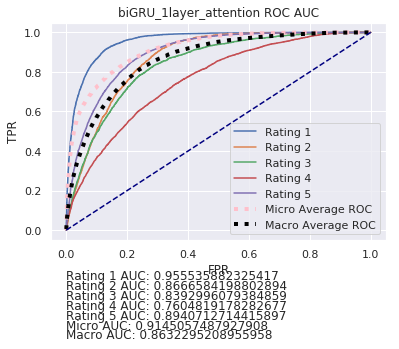

In [47]:
import util.plot_util as pu

model_name = "biGRU_1layer_attention"
roc_auc = json.loads(report.loc[report.model_name == model_name, "roc_auc"].values[0])
tpr = json.loads(report.loc[report.model_name == model_name, "tpr"].values[0])
fpr = json.loads(report.loc[report.model_name == model_name, "fpr"].values[0])

pu.plot_roc_auc(model_name, roc_auc, fpr, tpr)


### ROC AUC

When looking at ROC AUC, our base model did better than the rest of the models in all classes. If you look at sorting order, each model as you move to the left, did better than the other in all classes as well

# Conclusion

Looks like our base model (random embedding) not only trained faster than our pre-trained models, it also performed better in almost all scores (except for F1). 

Something that I did not record here is the time to create the weights for the pre-trained model. I used 110k reviews with a 75% to 25% split for training and test which amounted to about 40k words in our vocabulary. This took about 20 minutes to contruct the weights for the embedding layer befoer training. Although with larger sample sizes, this may become neglible but with only 110k samples, it was pretty significant and was almost 60% of the training time.

We should stick with random embeddings for future tests